## <center> `Spam Detection Using Fine-Tuned BERT` </center>

`Dataset:`
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

`Objective:`
Build an AI model that can classify messages as spam or legitimate using BERT model


<a class="anchor" id="0.1"></a>
# **Table of Contents**

1. [Loading Data](#1)
2. [Data Preparation](#2)
3. [Exploratory Data Analysis (EDA)](#3)
4. [Original Data](#4)
   1. [Train/Test Splitting](#4.1)
   2. [Model Building](#4.2)
   3. [Model Evaluation](#4.3)
5. [Hyperparameter Tuning with Keras Tuner (Original Data)](#5)
   1. [Model Building](#5.1)
   2. [Model Evaluation](#5.2)
   3. [Additional Metrics (ROC-AUC) for BERT](#5.3)
6. [Downsampling Data](#6)
   1. [Train/Test Splitting](#6.1)
   2. [Model Building](#6.2)
   3. [Model Evaluation](#6.3)
7. [Hyperparameter Tuning with Keras Tuner (Downsampled Data)](#7)
   1. [Model Building](#7.1)
   2. [Model Evaluation](#7.2)
   3. [Additional Metrics (ROC-AUC) for BERT](#7.3)
8. [Upsampling Data](#8)
   1. [Train/Test Splitting](#8.1)
   2. [Model Building](#8.2)
   3. [Model Evaluation](#8.3)
9. [Hyperparameter Tuning with Keras Tuner (Upsampled Data)](#9)
   1. [Model Building](#9.1)
   2. [Model Evaluation](#9.2)
   3. [Additional Metrics (ROC-AUC) for BERT](#9.3)
10. [Class Weights](#10)
    1. [Model Building](#10.1)
    2. [Model Evaluation](#10.2)
11. [Hyperparameter Tuning with Keras Tuner (Class Weights)](#11)
    1. [Model Building](#11.1)
    2. [Model Evaluation](#11.2)
    3. [Additional Metrics (ROC-AUC) for BERT](#11.3)
12. [Custom Loss](#12)
    1. [Model Building](#12.1)
    2. [Model Evaluation](#12.2)
13. [Hyperparameter Tuning with Keras Tuner (Custom Loss)](#13)
    1. [Model Building](#13.1)
    2. [Model Evaluation](#13.2)
    3. [Additional Metrics (ROC-AUC) for BERT](#13.3)
14. [Performance Comparison of Fine-Tuned BERT](#14)
15. [Performance Comparison of Hyperparameter-Tuned BERT](#15)
16. [Inference Comparison of Fine-Tuned BERT](#16)
17. [Inference Comparison of Hyperparameter-Tuned BERT](#17)
18. [Conclusion](#18)
19. [Deployment](#19)
20. [References](#20)

## Loading Data
<a class="anchor" id="1"></a>
[Table of Contents](#0.1)

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import os
import joblib
import warnings #ignore warning
warnings.filterwarnings("ignore")

In [2]:
# Define file path
filepath ="D://Portfolio//Internship//AFAME//Project details//Spam SMS Detection//spam.csv"
# Read the CSV file into a DataFrame with specified encoding
data = pd.read_csv(filepath, encoding='latin1')
# Display the first few rows of the DataFrame
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## Data Preparation
<a class="anchor" id="2"></a>
[Table of Contents](#0.1)

In [4]:
# removing excess unnecessary column 
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data.rename(columns={'v1': 'Class', 'v2': 'Text'}, inplace=True)

In [6]:
data['Class'] = data['Class'].map({'ham':0, 'spam':1})
data.head()

,Class,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Checking null values
data.isnull().sum()

Class    0
Text     0
dtype: int64

In [8]:
data.duplicated().sum()

403

We are dropping the duplicate values as they are crucial for our task of identifying spam SMS messages.

In [9]:
data = data.drop_duplicates()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   5169 non-null   int64 
 1   Text    5169 non-null   object
dtypes: int64(1), object(1)
memory usage: 121.1+ KB


In [11]:
# Viewing values in 'v1' column
data['Class'].value_counts()

Class
0    4516
1     653
Name: count, dtype: int64

In [12]:
data.groupby('Class').describe()

Text                                                               
      count unique                                                top freq
Class                                                                     
0      4516   4516  Go until jurong point, crazy.. Available only ...    1
1       653    653  Free entry in 2 a wkly comp to win FA Cup fina...    1

In [13]:
# Viewing the imbalanced rate
653/4516

0.1445969884853853

In [14]:
# Viewing unique values in 'v2'
data['Text'].nunique()

5169

## Exploratory Data Analysis (EDA)
<a class="anchor" id="3"></a>
[Table of Contents](#0.1)

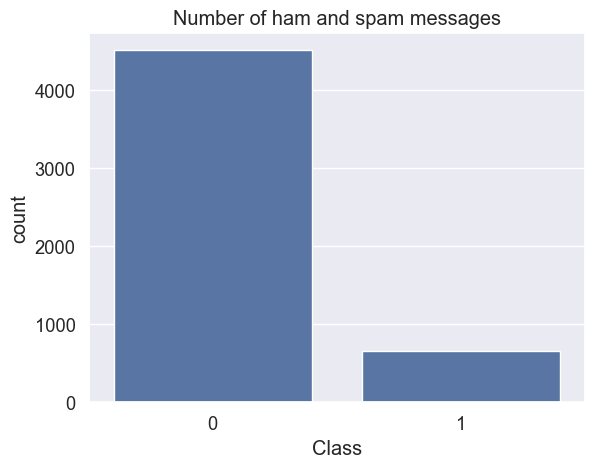

In [15]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(data=data, x= 'Class').set_title("Number of ham and spam messages")
plt.show()

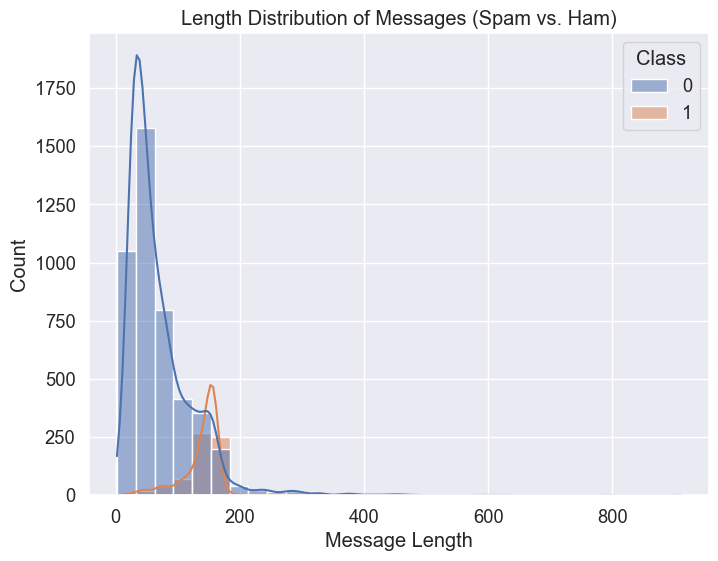

In [16]:
# Plot the distribution of message lengths
plt.figure(figsize=(8, 6))
sns.histplot(x=data['Text'].str.len(), bins=30, hue=data['Class'], kde=True)
plt.title('Length Distribution of Messages (Spam vs. Ham)')
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

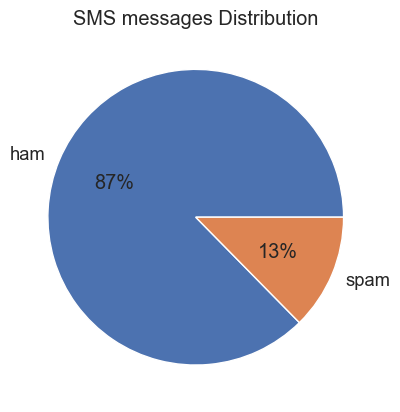

In [17]:
sms = pd.value_counts(data["Class"], sort=True)
sms.plot(kind="pie", labels=["ham", "spam"], autopct="%1.0f%%")

plt.title("SMS messages Distribution")
plt.ylabel("")
plt.show()

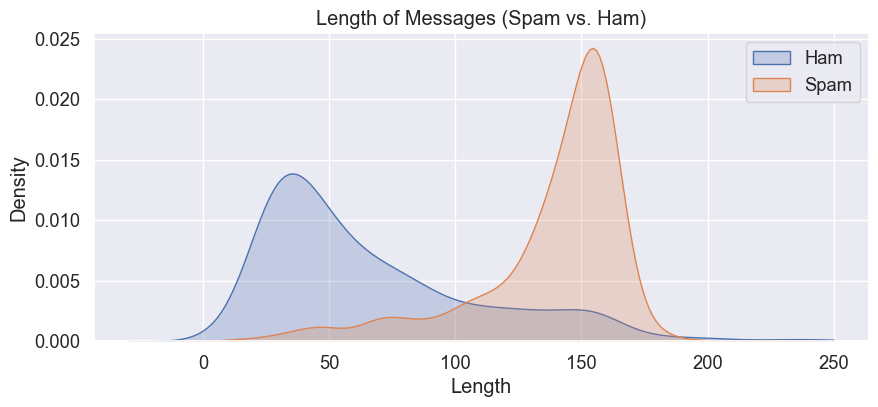

In [18]:
# Calculate lengths of messages directly in the plotting function
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(data.loc[data.Class == 0, 'Text'].str.len(), shade=True, label='Ham', clip=(-50, 250))
sns.kdeplot(data.loc[data.Class == 1, 'Text'].str.len(), shade=True, label='Spam', clip=(-50, 250))

# Set axis labels and title
ax.set(
    xlabel='Length',
    ylabel='Density',
    title='Length of Messages (Spam vs. Ham)'
)
ax.legend(loc='upper right')

# Show plot
plt.show()

## Original Data
<a class="anchor" id="4"></a>
[Table of Contents](#0.1)

### Train/Test Spliting
<a class="anchor" id="4.1"></a>
[Table of Contents](#0.1)

In [19]:
X = data['Text']
y = data['Class']

In [20]:
X.shape

(5169,)

In [21]:
y.shape

(5169,)

In [22]:
print(f'Length of X: {len(X)}')
print(f'Length of y: {len(y)}')

Length of X: 5169
Length of y: 5169


In [23]:
from sklearn.model_selection import train_test_split
random_seed = 42

# Split data into training and temporary sets (60% train, 40% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_seed, stratify = y)

# Split temporary set into validation and test sets (20% val, 20% test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed, stratify = y_temp)

print(f'Training data: {len(X_train)}, {len(y_train)}')
print(f'Validation data: {len(X_val)}, {len(y_val)}') 
print(f'Testing data: {len(X_test)}, {len(y_test)}') 

Training data: 3618, 3618
Validation data: 775, 775
Testing data: 776, 776


## Model Building
<a class="anchor" id="4.2"></a>
[Table of Contents](#0.1)

In [24]:
%%time
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3') # loading Bert Preprocessor
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4') # Loading Bert Encoder

CPU times: total: 11.9 s
Wall time: 13 s


In [25]:
%%time
from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam  # Import the optimizer

# Functional BERT layers
text_input = Input(shape=(), dtype=tf.string, name='Inputs')
encoder_inputs = bert_preprocessor(text_input)
embbed = bert_encoder(encoder_inputs)

# Neural Network layers
dropout1 = Dropout(0.1, name='Dropout1')(embbed['pooled_output'])
dense1 = Dense(128, activation='relu', name='Dense1')(dropout1)
batch_norm1 = BatchNormalization(name='BatchNorm1')(dense1)
dropout2 = Dropout(0.1, name='Dropout2')(batch_norm1)
dense2 = Dense(64, activation='relu', name='Dense2')(dropout2)
batch_norm2 = BatchNormalization(name='BatchNorm2')(dense2)
dropout3 = Dropout(0.1, name='Dropout3')(batch_norm2)
outputs = Dense(1, activation='sigmoid', name='Output')(dropout3)

# Creating final model
model = Model(inputs=[text_input], outputs=[outputs])

CPU times: total: 656 ms
Wall time: 784 ms


In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['Inputs[0][0]']                 
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [27]:
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = metrics)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3, 
                               restore_best_weights=True)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.2, 
                                 patience=2, 
                                 min_lr=1e-7)

In [29]:
%%time
# Fit the model
history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
114/114 [==============================] - 70s 535ms/step - loss: 0.4402 - accuracy: 0.8237 - precision: 0.4103 - recall: 0.9059 - val_loss: 0.2324 - val_accuracy: 0.9058 - val_precision: 1.0000 - val_recall: 0.2551 - lr: 0.0010
Epoch 2/20
114/114 [==============================] - 61s 532ms/step - loss: 0.1881 - accuracy: 0.9514 - precision: 0.7728 - recall: 0.8709 - val_loss: 0.1466 - val_accuracy: 0.9755 - val_precision: 0.9540 - val_recall: 0.8469 - lr: 0.0010
Epoch 3/20
114/114 [==============================] - 61s 536ms/step - loss: 0.1200 - accuracy: 0.9682 - precision: 0.8717 - recall: 0.8775 - val_loss: 0.0974 - val_accuracy: 0.9665 - val_precision: 0.9615 - val_recall: 0.7653 - lr: 0.0010
Epoch 4/20
114/114 [==============================] - 60s 530ms/step - loss: 0.1058 - accuracy: 0.9696 - precision: 0.8881 - recall: 0.8687 - val_loss: 0.0834 - val_accuracy: 0.9729 - val_precision: 0.9639 - val_recall: 0.8163 - lr: 0.0010
Epoch 5/20
114/114 [====================

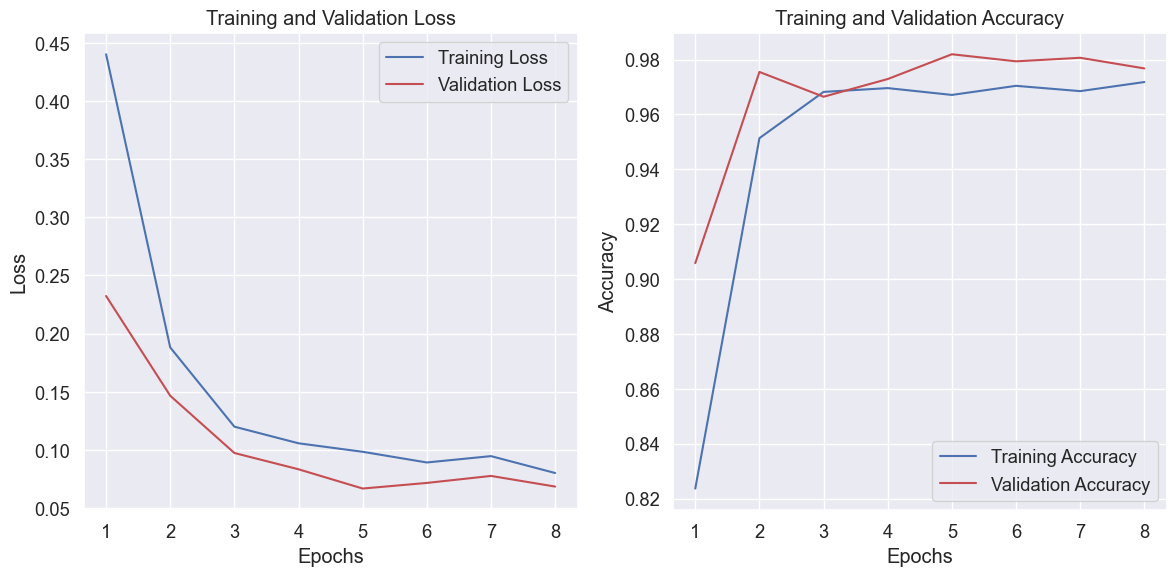

In [30]:
# Extract loss and accuracy for training and validation from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a range object for the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

## Model Evaluation
<a class="anchor" id="4.3"></a>
[Table of Contents](#0.1)

In [31]:
# Evaluate the model
results = model.evaluate(X_test, y_test)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

25/25 [==============================] - 10s 419ms/step - loss: 0.0521 - accuracy: 0.9858 - precision: 0.9485 - recall: 0.9388
Test Loss: 0.05211685970425606
Test Accuracy: 0.9858247637748718


In [32]:
y_predict = model.predict(X_test)
y_predict = y_predict.flatten()

25/25 [==============================] - 11s 421ms/step


In [33]:
y_predict = np.where(y_predict > 0.5,1,0)
y_predict

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

In [34]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predict)
cm

array([[673,   5],
       [  6,  92]], dtype=int64)

Text(43.25, 0.5, 'Actual')

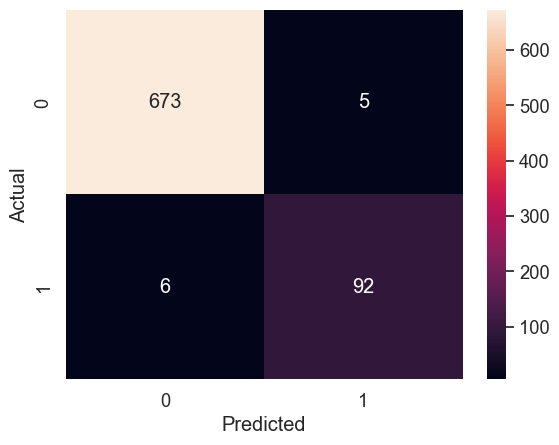

In [35]:
sns.heatmap(cm, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [36]:
from sklearn.metrics import classification_report

nml = classification_report(y_test, y_predict, target_names=['Ham', 'Spam'])
print(nml)

              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       678
        Spam       0.95      0.94      0.94        98

    accuracy                           0.99       776
   macro avg       0.97      0.97      0.97       776
weighted avg       0.99      0.99      0.99       776



## Inference

In [37]:
# Actual real examples
reviews = [
    'You will be hired at managerial roles in top companies',
    'Citrusbug Technolabs is hiring for AI/ML Engineer + 14 new Fresher Data Science jobs',
    'Job opportunity from Wipro just for You!',
    'Dear Congratulations - Get Your Job Offer Letter @ Cognizant',
    'Practice Coding with A Very Big Sum'
]

# Detection of examples
nml_inf = model.predict(reviews)
nml_inf

1/1 [==============================] - 1s 783ms/step


array([[0.04189568],
       [0.52800953],
       [0.04187298],
       [0.29887256],
       [0.00634511]], dtype=float32)

## Hyperparameter Tuning with Keras Tuner (Original Data)
<a class="anchor" id="5"></a>
[Table of Contents](#0.1)

In [38]:
%%time
import kerastuner as kt

# Function to compile your existing model with hyperparameters
def compile_model(hp):
    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Compile the model with the chosen learning rate
    model.compile(optimizer = Adam(learning_rate=learning_rate),
                  loss = 'binary_crossentropy',
                  metrics = metrics)
    return model

# Initialize Keras Tuner with the existing model
tuner = kt.Hyperband(
    compile_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory=os.getcwd(),
    project_name='nml_model'
)

# Perform hyperparameter tuning
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

# Get the best model
best_model_nml = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from C:\Users\sathi\Career\Internship\AFAME\Spam SMS Detection\BERT\nml_model\tuner0.json
CPU times: total: 1.53 s
Wall time: 2.2 s


In [39]:
# Evaluate the best model on the validation set
hp_results_val = best_model_nml.evaluate(X_val, y_val)
print(f"\nValidation Loss: {hp_results_val[0]}")
print(f"Validation Accuracy: {hp_results_val[1]}")

25/25 [==============================] - 12s 418ms/step - loss: 0.0490 - accuracy: 0.9865 - precision: 0.9581 - recall: 0.9337

Validation Loss: 0.04902127757668495
Validation Accuracy: 0.9864603281021118


In [40]:
# Evaluate the best model on the test set
hp_results_test = best_model_nml.evaluate(X_test, y_test)
print(f"\Test Loss: {hp_results_test[0]}")
print(f"Test Accuracy: {hp_results_test[1]}")

25/25 [==============================] - 11s 421ms/step - loss: 0.0315 - accuracy: 0.9910 - precision: 0.9789 - recall: 0.9490
\Test Loss: 0.03152916207909584
Test Accuracy: 0.9909793734550476


## Model Building
<a class="anchor" id="5.1"></a>
[Table of Contents](#0.1)

In [41]:
%%time
# Fitting best model on X_train, y_train, X_val, y_val, X_test, y_test
best_model_nml.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
114/114 [==============================] - 63s 524ms/step - loss: 0.0713 - accuracy: 0.9793 - precision: 0.9321 - recall: 0.9015 - val_loss: 0.0498 - val_accuracy: 0.9832 - val_precision: 0.9670 - val_recall: 0.8980 - lr: 1.0000e-04
Epoch 2/20
114/114 [==============================] - 60s 525ms/step - loss: 0.0702 - accuracy: 0.9760 - precision: 0.9243 - recall: 0.8818 - val_loss: 0.0479 - val_accuracy: 0.9845 - val_precision: 0.9674 - val_recall: 0.9082 - lr: 1.0000e-04
Epoch 3/20
114/114 [==============================] - 60s 530ms/step - loss: 0.0604 - accuracy: 0.9807 - precision: 0.9428 - recall: 0.9015 - val_loss: 0.0473 - val_accuracy: 0.9845 - val_precision: 0.9674 - val_recall: 0.9082 - lr: 1.0000e-04
Epoch 4/20
114/114 [==============================] - 59s 515ms/step - loss: 0.0630 - accuracy: 0.9798 - precision: 0.9384 - recall: 0.8993 - val_loss: 0.0478 - val_accuracy: 0.9845 - val_precision: 0.9674 - val_recall: 0.9082 - lr: 1.0000e-04
Epoch 5/20
114/114 [====

## Model Evaluation
<a class="anchor" id="5.2"></a>
[Table of Contents](#0.1)

In [43]:
y_predict_hp = best_model_nml.predict(X_test)
y_predict_hp = y_predict_hp.flatten()

25/25 [==============================] - 11s 406ms/step


In [44]:
y_predict_hp = np.where(y_predict_hp > 0.5,1,0)
y_predict_hp

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

In [45]:
cm_hp = confusion_matrix(y_test, y_predict_hp)
cm_hp

array([[678,   0],
       [  5,  93]], dtype=int64)

Text(43.25, 0.5, 'Actual')

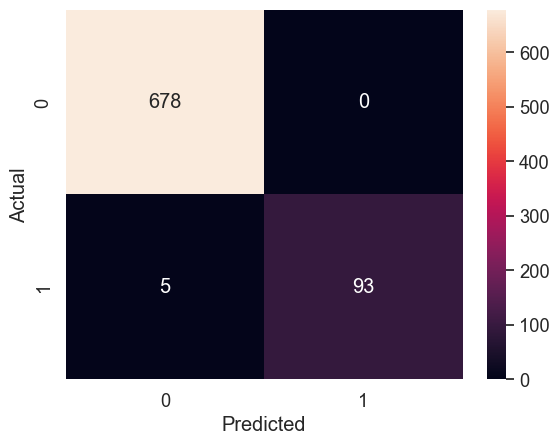

In [46]:
sns.heatmap(cm_hp, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [47]:
nml_hp = classification_report(y_test, y_predict_hp, target_names=['Ham', 'Spam'])
print(nml_hp)

              precision    recall  f1-score   support

         Ham       0.99      1.00      1.00       678
        Spam       1.00      0.95      0.97        98

    accuracy                           0.99       776
   macro avg       1.00      0.97      0.99       776
weighted avg       0.99      0.99      0.99       776



## Additional Metrics (ROC-AUC) for BERT
<a class="anchor" id="5.3"></a>
[Table of Contents](#0.1)

In [48]:
from sklearn.metrics import roc_auc_score

roc_auc_test = roc_auc_score(y_test, y_predict_hp)
print(f'ROC-AUC Score on Test Set: {roc_auc_test:.4f}')

ROC-AUC Score on Test Set: 0.9745


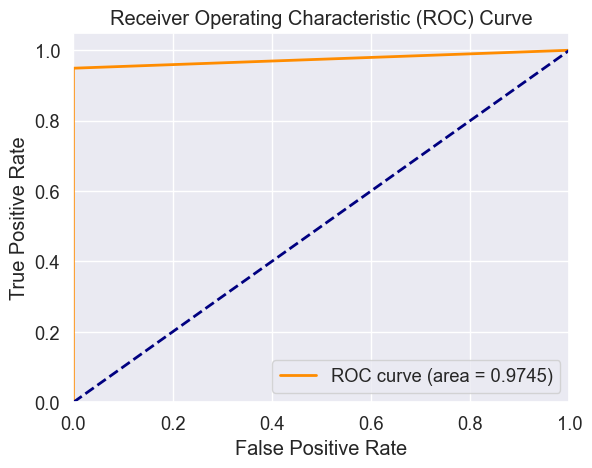

In [49]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test and y_predict_hp are already defined
fpr, tpr, _ = roc_curve(y_test, y_predict_hp)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [50]:
# Detection of examples
nml_inf_hp = best_model_nml.predict(reviews)
nml_inf_hp

1/1 [==============================] - 1s 705ms/step


array([[0.03139546],
       [0.5518679 ],
       [0.19162832],
       [0.44041386],
       [0.00502677]], dtype=float32)

## Downsampling Data
<a class="anchor" id="6"></a>
[Table of Contents](#0.1)

In [51]:
data_dwn = data.copy(deep=True)

In [52]:
data_dwn.head()

,Class,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [53]:
data_spam = data_dwn[data_dwn['Class']==1]
data_spam.shape

(653, 2)

In [54]:
data_ham = data_dwn[data_dwn['Class']==0]
data_ham.shape

(4516, 2)

In [55]:
data_ham_downsampled = data_ham.sample(data_spam.shape[0])
data_ham_downsampled.shape

(653, 2)

In [56]:
data_balanced_dwn = pd.concat([data_spam,data_ham_downsampled])
data_balanced_dwn.shape

(1306, 2)

In [57]:
data_balanced_dwn['Class'].value_counts()

Class
1    653
0    653
Name: count, dtype: int64

## Train/Test Splitting
<a class="anchor" id="6.1"></a>
[Table of Contents](#0.1)

In [58]:
X_dwn = data_balanced_dwn['Text']
y_dwn = data_balanced_dwn['Class']

In [59]:
# Split data into training and temporary sets (60% train, 40% temp)
X_train_dwn, X_temp_dwn, y_train_dwn, y_temp_dwn = train_test_split(X_dwn, y_dwn, test_size=0.3, random_state=random_seed, stratify = y_dwn)

# Split temporary set into validation and test sets (20% val, 20% test)
X_val_dwn, X_test_dwn, y_val_dwn, y_test_dwn = train_test_split(X_temp_dwn, y_temp_dwn, test_size=0.5, random_state=random_seed, stratify = y_temp_dwn)

print(f'Training data: {len(X_train_dwn)}, {len(y_train_dwn)}')
print(f'Validation data: {len(X_val_dwn)}, {len(y_val_dwn)}') 
print(f'Testing data: {len(X_test_dwn)}, {len(y_test_dwn)}') 

Training data: 914, 914
Validation data: 196, 196
Testing data: 196, 196


## Model Building
<a class="anchor" id="6.2"></a>
[Table of Contents](#0.1)

In [60]:
%%time
# Fit the model
history_dwn = model.fit(X_train_dwn, y_train_dwn, epochs=20, 
                    validation_data=(X_val_dwn, y_val_dwn), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
29/29 [==============================] - 15s 520ms/step - loss: 0.8676 - accuracy: 0.7287 - precision: 1.0000 - recall: 0.4573 - val_loss: 0.1464 - val_accuracy: 0.9592 - val_precision: 1.0000 - val_recall: 0.9184 - lr: 4.0000e-06
Epoch 2/20
29/29 [==============================] - 15s 511ms/step - loss: 0.8376 - accuracy: 0.7298 - precision: 1.0000 - recall: 0.4595 - val_loss: 0.2046 - val_accuracy: 0.9337 - val_precision: 1.0000 - val_recall: 0.8673 - lr: 4.0000e-06
Epoch 3/20
29/29 [==============================] - 15s 509ms/step - loss: 0.8209 - accuracy: 0.7188 - precision: 1.0000 - recall: 0.4376 - val_loss: 0.2596 - val_accuracy: 0.9133 - val_precision: 1.0000 - val_recall: 0.8265 - lr: 4.0000e-06
Epoch 4/20
29/29 [==============================] - 15s 515ms/step - loss: 0.8396 - accuracy: 0.7254 - precision: 1.0000 - recall: 0.4508 - val_loss: 0.3261 - val_accuracy: 0.8980 - val_precision: 1.0000 - val_recall: 0.7959 - lr: 8.0000e-07
CPU times: total: 1min 15s
Wall 

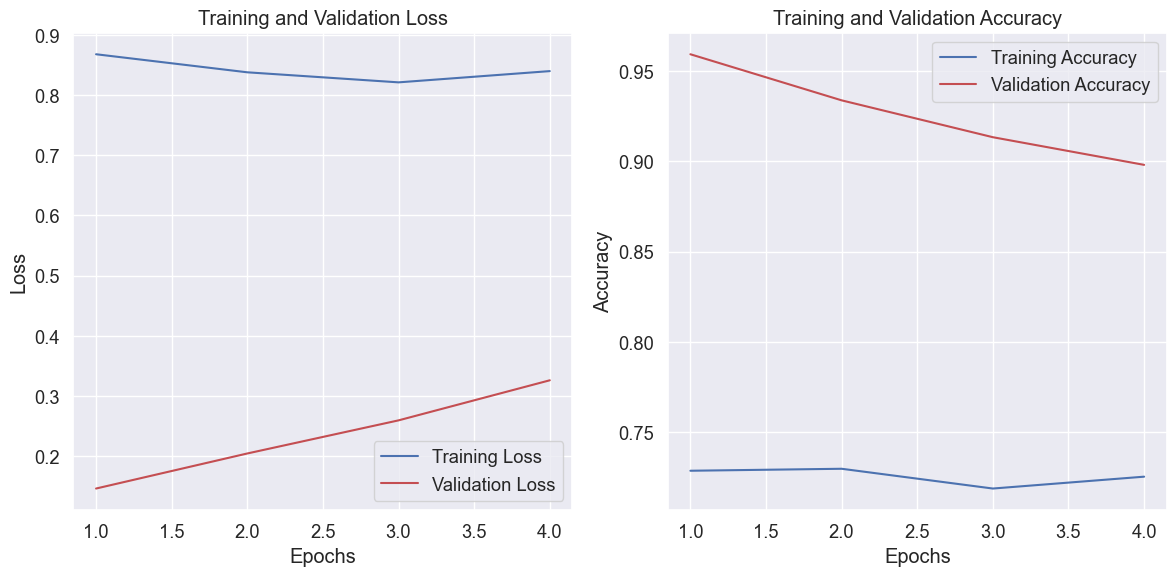

In [61]:
# Extract loss and accuracy for training and validation from the history object
train_loss = history_dwn.history['loss']
val_loss = history_dwn.history['val_loss']
train_accuracy = history_dwn.history['accuracy']
val_accuracy = history_dwn.history['val_accuracy']

# Create a range object for the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

### Model Evaluation
<a class="anchor" id="6.3"></a>
[Table of Contents](#0.1)

In [62]:
# Evaluate the model
results_dwn = model.evaluate(X_test_dwn, y_test_dwn)
print(f"Test Loss: {results_dwn[0]}")
print(f"Test Accuracy: {results_dwn[1]}")

7/7 [==============================] - 3s 361ms/step - loss: 0.1266 - accuracy: 0.9592 - precision: 1.0000 - recall: 0.9184
Test Loss: 0.1266266405582428
Test Accuracy: 0.9591836929321289


In [63]:
y_predict_dwn = model.predict(X_test_dwn)
y_predict_dwn = y_predict_dwn.flatten()

7/7 [==============================] - 3s 402ms/step


In [64]:
y_predict_dwn = np.where(y_predict_dwn > 0.5,1,0)
y_predict_dwn

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0])

In [65]:
cm_dwn = confusion_matrix(y_test_dwn, y_predict_dwn)
cm_dwn

array([[98,  0],
       [ 8, 90]], dtype=int64)

Text(43.25, 0.5, 'Actual')

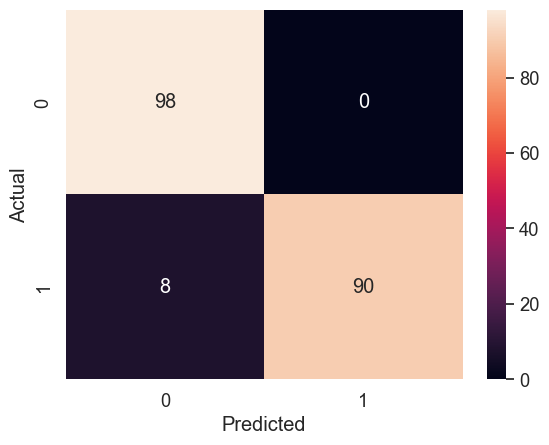

In [66]:
sns.heatmap(cm_dwn, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [67]:
dwn = classification_report(y_test_dwn, y_predict_dwn, target_names=['Ham', 'Spam'])
print(dwn)

              precision    recall  f1-score   support

         Ham       0.92      1.00      0.96        98
        Spam       1.00      0.92      0.96        98

    accuracy                           0.96       196
   macro avg       0.96      0.96      0.96       196
weighted avg       0.96      0.96      0.96       196



In [68]:
# Detection of examples
dwn_inf = model.predict(reviews)
dwn_inf

1/1 [==============================] - 0s 52ms/step


array([[0.01022932],
       [0.23287717],
       [0.07121247],
       [0.19026127],
       [0.00284273]], dtype=float32)

## Hyperparameter Tuning with Keras Tuner (Downsampled Data)
<a class="anchor" id="7"></a>
[Table of Contents](#0.1)

In [69]:
%%time
# Initialize Keras Tuner with the existing model
tuner = kt.Hyperband(
    compile_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory=os.getcwd(),
    project_name='dwn_model'
)

# Perform hyperparameter tuning
tuner.search(X_train_dwn, y_train_dwn, epochs=5, validation_data=(X_val_dwn, y_val_dwn))

# Get the best model
best_model_dwn = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from C:\Users\sathi\Career\Internship\AFAME\Spam SMS Detection\BERT\dwn_model\tuner0.json
CPU times: total: 1.27 s
Wall time: 1.69 s


In [70]:
# Evaluate the best model on the validation set
hp_results_val_dwn = best_model_dwn.evaluate(X_val_dwn, y_val_dwn)
print(f"\nValidation Loss: {hp_results_val[0]}")
print(f"Validation Accuracy: {hp_results_val[1]}")

7/7 [==============================] - 4s 366ms/step - loss: 0.0994 - accuracy: 0.9566 - precision: 0.9786 - recall: 0.9337

Validation Loss: 0.04902127757668495
Validation Accuracy: 0.9864603281021118


In [71]:
# Evaluate the best model on the Test set
hp_results_test_dwn = best_model_dwn.evaluate(X_test_dwn, y_test_dwn)
print(f"\Test Loss: {hp_results_test_dwn[0]}")
print(f"Test Accuracy: {hp_results_test_dwn[1]}")

7/7 [==============================] - 3s 367ms/step - loss: 0.0629 - accuracy: 0.9796 - precision: 0.9896 - recall: 0.9694
\Test Loss: 0.06288964301347733
Test Accuracy: 0.9795918464660645


## Model Building
<a class="anchor" id="7.1"></a>
[Table of Contents](#0.1)

In [72]:
%%time
# Fitting best model on X_train, y_train, X_val, y_val, X_test, y_test
best_model_dwn.fit(X_train_dwn, y_train_dwn, epochs=20, 
                    validation_data=(X_val_dwn, y_val_dwn), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
29/29 [==============================] - 18s 531ms/step - loss: 0.2720 - accuracy: 0.9289 - precision: 0.9712 - recall: 0.8840 - val_loss: 0.2406 - val_accuracy: 0.9235 - val_precision: 0.8739 - val_recall: 0.9898 - lr: 0.0010
Epoch 2/20
29/29 [==============================] - 15s 519ms/step - loss: 0.2761 - accuracy: 0.9201 - precision: 0.9444 - recall: 0.8928 - val_loss: 0.1539 - val_accuracy: 0.9541 - val_precision: 0.9238 - val_recall: 0.9898 - lr: 0.0010
Epoch 3/20
29/29 [==============================] - 15s 519ms/step - loss: 0.1566 - accuracy: 0.9573 - precision: 0.9686 - recall: 0.9453 - val_loss: 0.4503 - val_accuracy: 0.8316 - val_precision: 0.7519 - val_recall: 0.9898 - lr: 0.0010
Epoch 4/20
29/29 [==============================] - 15s 533ms/step - loss: 0.1556 - accuracy: 0.9540 - precision: 0.9705 - recall: 0.9365 - val_loss: 0.1310 - val_accuracy: 0.9490 - val_precision: 0.9400 - val_recall: 0.9592 - lr: 0.0010
Epoch 5/20
29/29 [==============================

## Model Evaluation
<a class="anchor" id="7.2"></a>
[Table of Contents](#0.1)

In [73]:
y_predict_hp_dwn = best_model_dwn.predict(X_test_dwn)
y_predict_hp_dwn = y_predict_hp_dwn.flatten()

7/7 [==============================] - 3s 407ms/step


In [74]:
y_predict_hp_dwn = np.where(y_predict_hp_dwn > 0.5,1,0)
y_predict_hp_dwn

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0])

In [75]:
cm_hp_dwn = confusion_matrix(y_test_dwn, y_predict_hp_dwn)
cm_hp_dwn

array([[95,  3],
       [ 1, 97]], dtype=int64)

Text(43.25, 0.5, 'Actual')

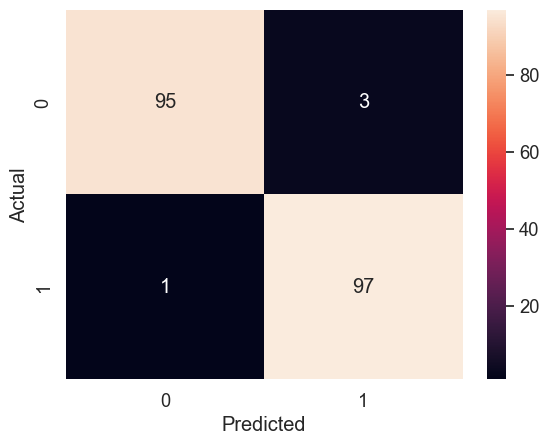

In [76]:
sns.heatmap(cm_hp_dwn, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [77]:
dwn_hp = classification_report(y_test_dwn, y_predict_hp_dwn, target_names=['Ham', 'Spam'])
print(dwn_hp)

              precision    recall  f1-score   support

         Ham       0.99      0.97      0.98        98
        Spam       0.97      0.99      0.98        98

    accuracy                           0.98       196
   macro avg       0.98      0.98      0.98       196
weighted avg       0.98      0.98      0.98       196



## Additional Metrics (ROC-AUC) for BERT
<a class="anchor" id="7.3"></a>
[Table of Contents](#0.1)

In [78]:
roc_auc_test = roc_auc_score(y_test_dwn, y_predict_hp_dwn)
print(f'ROC-AUC Score on Test Set: {roc_auc_test:.4f}')

ROC-AUC Score on Test Set: 0.9796


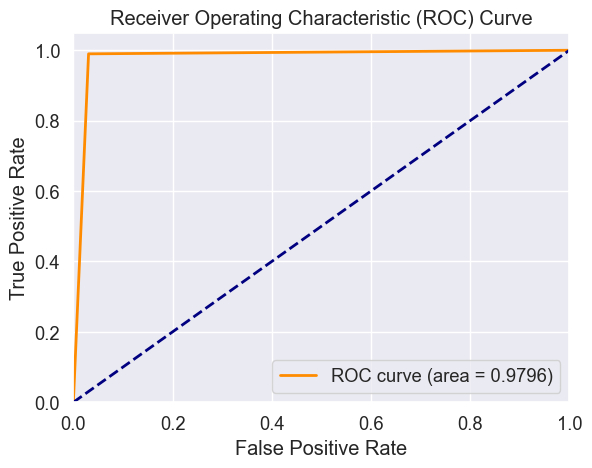

In [79]:
# y_test and y_predict_hp are already defined
fpr, tpr, _ = roc_curve(y_test_dwn, y_predict_hp_dwn)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [80]:
# Detection of examples
dwn_inf_hp = best_model_dwn.predict(reviews)
dwn_inf_hp

1/1 [==============================] - 1s 729ms/step


array([[0.23240902],
       [0.72064584],
       [0.83650786],
       [0.9270451 ],
       [0.00124681]], dtype=float32)

## Upsampling Data
<a class="anchor" id="8"></a>
[Table of Contents](#0.1)

In [81]:
data_up = data.copy(deep=True)
data_up

,Class,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [82]:
data_spam_up = data_up[data_up['Class']==1]
data_spam_up.shape

(653, 2)

In [83]:
data_ham_up = data_up[data_up['Class']==0]
data_ham_up.shape

(4516, 2)

In [84]:
data_spam_upsampled = data_spam_up.sample(data_ham_up.shape[0], replace=True)
data_spam_upsampled.shape

(4516, 2)

In [85]:
data_balanced_up = pd.concat([data_ham_up,data_spam_upsampled])
data_balanced_up.shape

(9032, 2)

In [86]:
data_balanced_up['Class'].value_counts()

Class
0    4516
1    4516
Name: count, dtype: int64

## Train/Test Splitting
<a class="anchor" id="8.1"></a>
[Table of Contents](#0.1)

In [87]:
X_up = data_balanced_up['Text']
y_up = data_balanced_up['Class']

In [88]:
# Split data into training and temporary sets (60% train, 40% temp)
X_train_up, X_temp_up, y_train_up, y_temp_up = train_test_split(X_up, y_up, test_size=0.3, random_state=random_seed, stratify = y_up)

# Split temporary set into validation and test sets (20% val, 20% test)
X_val_up, X_test_up, y_val_up, y_test_up = train_test_split(X_temp_up, y_temp_up, test_size=0.5, random_state=random_seed, stratify = y_temp_up)

print(f'Training data: {len(X_train_up)}, {len(y_train_up)}')
print(f'Validation data: {len(X_val_up)}, {len(y_val_up)}') 
print(f'Testing data: {len(X_test_up)}, {len(y_test_up)}') 

Training data: 6322, 6322
Validation data: 1355, 1355
Testing data: 1355, 1355


## Model Building
<a class="anchor" id="8.2"></a>
[Table of Contents](#0.1)

In [89]:
%%time
# Fit the model
history_up = model.fit(X_train_up, y_train_up, epochs=20, 
                    validation_data=(X_val_up, y_val_up), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
198/198 [==============================] - 104s 528ms/step - loss: 0.1381 - accuracy: 0.9527 - precision: 0.9563 - recall: 0.9488 - val_loss: 0.0666 - val_accuracy: 0.9764 - val_precision: 0.9695 - val_recall: 0.9838 - lr: 4.0000e-05
Epoch 2/20
198/198 [==============================] - 103s 521ms/step - loss: 0.1313 - accuracy: 0.9570 - precision: 0.9590 - recall: 0.9548 - val_loss: 0.0664 - val_accuracy: 0.9801 - val_precision: 0.9766 - val_recall: 0.9838 - lr: 4.0000e-05
Epoch 3/20
198/198 [==============================] - 103s 519ms/step - loss: 0.1245 - accuracy: 0.9573 - precision: 0.9590 - recall: 0.9554 - val_loss: 0.0672 - val_accuracy: 0.9779 - val_precision: 0.9723 - val_recall: 0.9838 - lr: 4.0000e-05
Epoch 4/20
198/198 [==============================] - 102s 518ms/step - loss: 0.1306 - accuracy: 0.9540 - precision: 0.9533 - recall: 0.9548 - val_loss: 0.0654 - val_accuracy: 0.9786 - val_precision: 0.9737 - val_recall: 0.9838 - lr: 4.0000e-05
Epoch 5/20
198/198 [

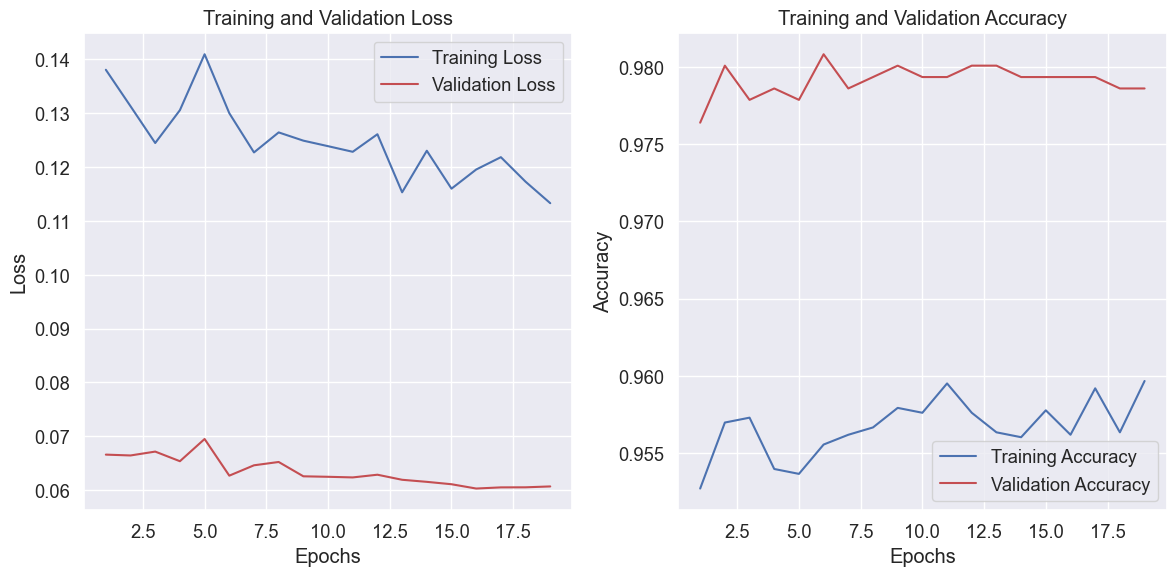

In [90]:
# Extract loss and accuracy for training and validation from the history object
train_loss = history_up.history['loss']
val_loss = history_up.history['val_loss']
train_accuracy = history_up.history['accuracy']
val_accuracy = history_up.history['val_accuracy']

# Create a range object for the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

## Model Evaluation
<a class="anchor" id="8.3"></a>
[Table of Contents](#0.1)

In [91]:
# Evaluate the model
results_up = model.evaluate(X_test_up, y_test_up)
print(f"Test Loss: {results_up[0]}")
print(f"Test Accuracy: {results_up[1]}")

43/43 [==============================] - 18s 427ms/step - loss: 0.0520 - accuracy: 0.9845 - precision: 0.9781 - recall: 0.9911
Test Loss: 0.05197938531637192
Test Accuracy: 0.984501838684082


In [92]:
y_predict_up = model.predict(X_test_up)
y_predict_up = y_predict_up.flatten()

43/43 [==============================] - 19s 441ms/step


In [93]:
y_predict_up = np.where(y_predict_up > 0.5,1,0)
y_predict_up

array([0, 1, 0, ..., 1, 1, 1])

In [94]:
cm_up = confusion_matrix(y_test_up, y_predict_up)
cm_up

array([[663,  15],
       [  6, 671]], dtype=int64)

Text(43.25, 0.5, 'Actual')

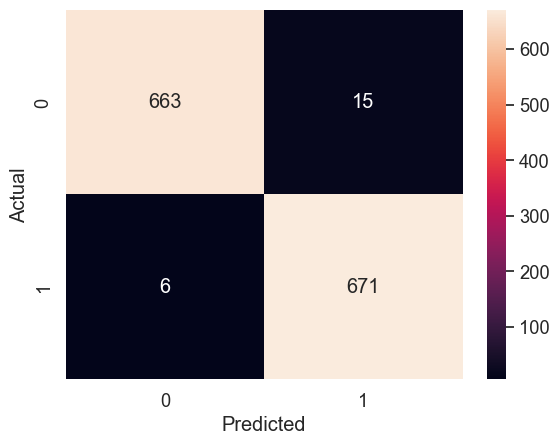

In [95]:
sns.heatmap(cm_up, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [96]:
up = classification_report(y_test_up, y_predict_up, target_names=['Ham', 'Spam'])
print(up)

              precision    recall  f1-score   support

         Ham       0.99      0.98      0.98       678
        Spam       0.98      0.99      0.98       677

    accuracy                           0.98      1355
   macro avg       0.98      0.98      0.98      1355
weighted avg       0.98      0.98      0.98      1355



In [97]:
# Detection of examples
up_inf = model.predict(reviews)
up_inf

1/1 [==============================] - 0s 52ms/step


array([[0.35127744],
       [0.808034  ],
       [0.7271071 ],
       [0.90419203],
       [0.00117756]], dtype=float32)

## Hyperparameter Tuning with Keras Tuner (Upsampled Data)
<a class="anchor" id="9"></a>
[Table of Contents](#0.1)

In [98]:
%%time
# Initialize Keras Tuner with the existing model
tuner = kt.Hyperband(
    compile_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory=os.getcwd(),
    project_name='up_model'
)

# Perform hyperparameter tuning
tuner.search(X_train_up, y_train_up, epochs=5, validation_data=(X_val_up, y_val_up))

# Get the best model
best_model_up = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from C:\Users\sathi\Career\Internship\AFAME\Spam SMS Detection\BERT\up_model\tuner0.json
CPU times: total: 1.73 s
Wall time: 2.12 s


In [99]:
# Evaluate the best model on the validation set
hp_results_val_up = best_model_up.evaluate(X_val_up, y_val_up)
print(f"\nValidation Loss: {hp_results_val_up[0]}")
print(f"Validation Accuracy: {hp_results_val_up[1]}")

43/43 [==============================] - 19s 423ms/step - loss: 0.3446 - accuracy: 0.9528 - precision: 0.9819 - recall: 0.9225

Validation Loss: 0.344561904668808
Validation Accuracy: 0.952767550945282


In [100]:
# Evaluate the best model on the Test set
hp_results_test_up = best_model_up.evaluate(X_test_up, y_test_up)
print(f"\Test Loss: {hp_results_test_up[0]}")
print(f"Test Accuracy: {hp_results_test_up[1]}")

43/43 [==============================] - 19s 433ms/step - loss: 0.2795 - accuracy: 0.9314 - precision: 0.9883 - recall: 0.8730
\Test Loss: 0.27953922748565674
Test Accuracy: 0.9313653111457825


## Model Building
<a class="anchor" id="9.1"></a>
[Table of Contents](#0.1)

In [101]:
%%time
# Fitting best model on X_train, y_train, X_val, y_val, X_test, y_test
best_model_up.fit(X_train_up, y_train_up, epochs=20, 
                    validation_data=(X_val_up, y_val_up), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
198/198 [==============================] - 108s 528ms/step - loss: 0.1900 - accuracy: 0.9296 - precision: 0.9333 - recall: 0.9253 - val_loss: 0.1852 - val_accuracy: 0.9365 - val_precision: 0.9983 - val_recall: 0.8746 - lr: 0.0100
Epoch 2/20
198/198 [==============================] - 104s 525ms/step - loss: 0.1497 - accuracy: 0.9440 - precision: 0.9434 - recall: 0.9446 - val_loss: 0.9622 - val_accuracy: 0.6339 - val_precision: 0.5775 - val_recall: 1.0000 - lr: 0.0100
Epoch 3/20
198/198 [==============================] - 104s 527ms/step - loss: 0.1427 - accuracy: 0.9502 - precision: 0.9529 - recall: 0.9472 - val_loss: 0.2732 - val_accuracy: 0.8886 - val_precision: 0.9981 - val_recall: 0.7788 - lr: 0.0100
Epoch 4/20
198/198 [==============================] - 106s 536ms/step - loss: 0.1211 - accuracy: 0.9548 - precision: 0.9633 - recall: 0.9456 - val_loss: 0.0632 - val_accuracy: 0.9786 - val_precision: 0.9880 - val_recall: 0.9690 - lr: 0.0020
Epoch 5/20
198/198 [================

## Model Evaluation
<a class="anchor" id="9.2"></a>
[Table of Contents](#0.1)

In [102]:
y_predict_hp_up = best_model_up.predict(X_test_up)
y_predict_hp_up = y_predict_hp_up.flatten()

43/43 [==============================] - 18s 415ms/step


In [103]:
y_predict_hp_up = np.where(y_predict_hp_up > 0.5,1,0)
y_predict_hp_up

array([0, 1, 0, ..., 1, 1, 1])

In [104]:
cm_hp_up = confusion_matrix(y_test_up, y_predict_hp_up)
cm_hp_up

array([[670,   8],
       [ 13, 664]], dtype=int64)

Text(43.25, 0.5, 'Actual')

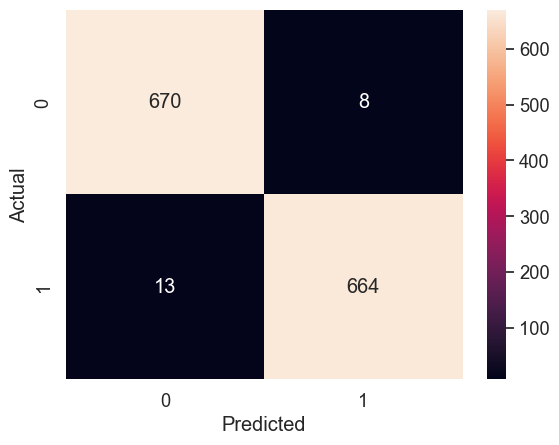

In [105]:
sns.heatmap(cm_hp_up, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [106]:
up_hp = classification_report(y_test_up, y_predict_hp_up, target_names=['Ham', 'Spam'])
print(up_hp)

              precision    recall  f1-score   support

         Ham       0.98      0.99      0.98       678
        Spam       0.99      0.98      0.98       677

    accuracy                           0.98      1355
   macro avg       0.98      0.98      0.98      1355
weighted avg       0.98      0.98      0.98      1355



## Additional Metrics (ROC-AUC) for BERT
<a class="anchor" id="9.3"></a>
[Table of Contents](#0.1)

In [107]:
roc_auc_test = roc_auc_score(y_test_up, y_predict_hp_up)
print(f'ROC-AUC Score on Test Set: {roc_auc_test:.4f}')

ROC-AUC Score on Test Set: 0.9845


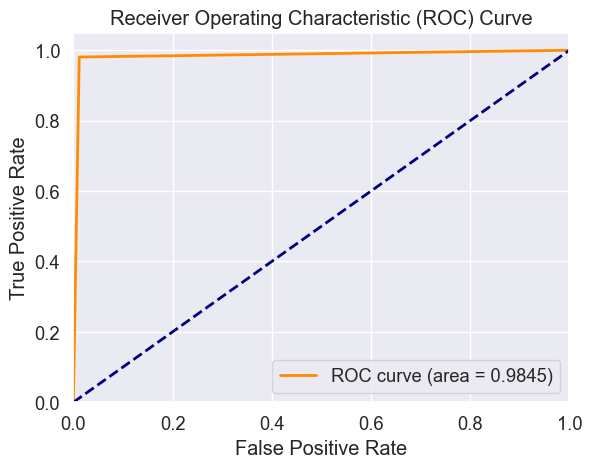

In [108]:
# y_test and y_predict_hp are already defined
fpr, tpr, _ = roc_curve(y_test_up, y_predict_hp_up)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [109]:
# Detection of examples
up_inf_hp = best_model_up.predict(reviews)
up_inf_hp

1/1 [==============================] - 1s 697ms/step


array([[0.25089422],
       [0.8353094 ],
       [0.631627  ],
       [0.85261863],
       [0.00646944]], dtype=float32)

## Class Weights
<a class="anchor" id="10"></a>
[Table of Contents](#0.1)

In [110]:
# Calculate class weights
class_weights = {
    0: len(y_train) / (2 * (len(y_train) - np.sum(y_train))),  # Weight for ham
    1: len(y_train) / (2 * np.sum(y_train))  # Weight for spam
}


In [111]:
%%time
clw_model = tf.keras.models.clone_model(model)

CPU times: total: 10.6 s
Wall time: 10.9 s


In [112]:
# Compile the model with class weights
clw_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics = metrics)

## Model Building
<a class="anchor" id="10.1"></a>
[Table of Contents](#0.1)

In [113]:
%%time
# Fit the model
history_clw = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_val, y_val), 
                    class_weight=class_weights,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
114/114 [==============================] - 63s 536ms/step - loss: 0.4238 - accuracy: 0.7424 - precision: 0.3288 - recall: 0.9978 - val_loss: 0.2310 - val_accuracy: 0.9097 - val_precision: 0.5833 - val_recall: 1.0000 - lr: 8.0000e-05
Epoch 2/20
114/114 [==============================] - 61s 535ms/step - loss: 0.3342 - accuracy: 0.7905 - precision: 0.3757 - recall: 0.9956 - val_loss: 0.3326 - val_accuracy: 0.8645 - val_precision: 0.4828 - val_recall: 1.0000 - lr: 8.0000e-05
Epoch 3/20
114/114 [==============================] - 60s 526ms/step - loss: 0.2719 - accuracy: 0.8259 - precision: 0.4198 - recall: 0.9912 - val_loss: 0.3327 - val_accuracy: 0.8671 - val_precision: 0.4876 - val_recall: 1.0000 - lr: 8.0000e-05
Epoch 4/20
114/114 [==============================] - 59s 520ms/step - loss: 0.2606 - accuracy: 0.8328 - precision: 0.4298 - recall: 0.9912 - val_loss: 0.3512 - val_accuracy: 0.8619 - val_precision: 0.4780 - val_recall: 1.0000 - lr: 1.6000e-05
CPU times: total: 5min 9

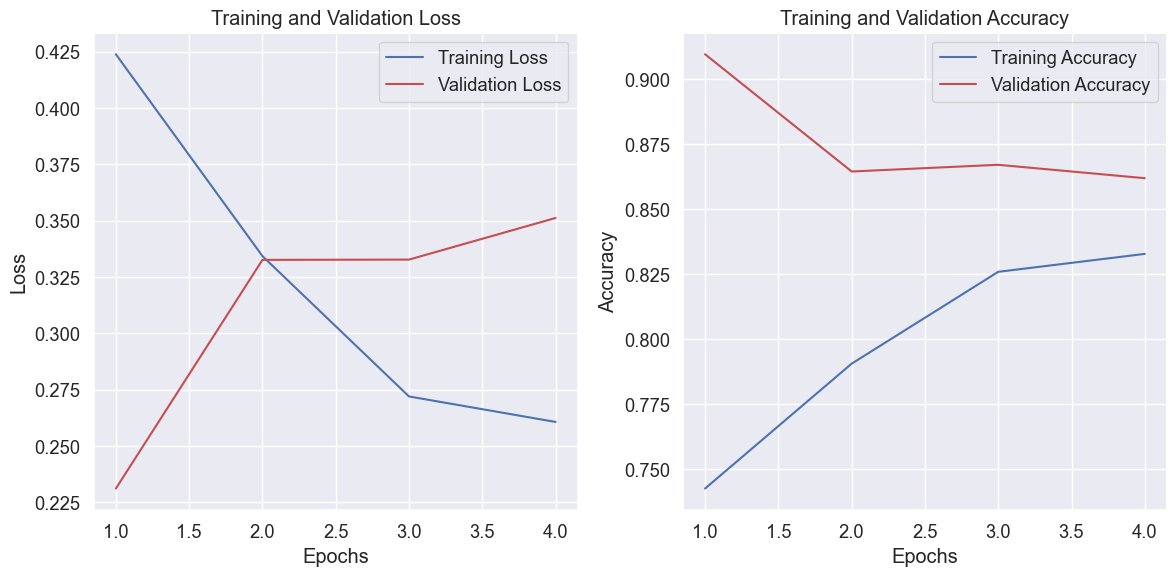

In [114]:
# Extract loss and accuracy for training and validation from the history object
train_loss = history_clw.history['loss']
val_loss = history_clw.history['val_loss']
train_accuracy = history_clw.history['accuracy']
val_accuracy = history_clw.history['val_accuracy']

# Create a range object for the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

## Model Evaluation
<a class="anchor" id="10.2"></a>
[Table of Contents](#0.1)

In [115]:
# Evaluate the model
results_clw = model.evaluate(X_test, y_test)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

25/25 [==============================] - 10s 413ms/step - loss: 0.2001 - accuracy: 0.9137 - precision: 0.5939 - recall: 1.0000
Test Loss: 0.05211685970425606
Test Accuracy: 0.9858247637748718


In [116]:
y_predict_clw = clw_model.predict(X_test)
y_predict_clw = y_predict_clw.flatten()

25/25 [==============================] - 11s 424ms/step


In [117]:
y_predict_clw = np.where(y_predict_clw > 0.5,1,0)
y_predict_clw

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [118]:
clw_cm = confusion_matrix(y_test, y_predict)
clw_cm

array([[673,   5],
       [  6,  92]], dtype=int64)

Text(43.25, 0.5, 'Actual')

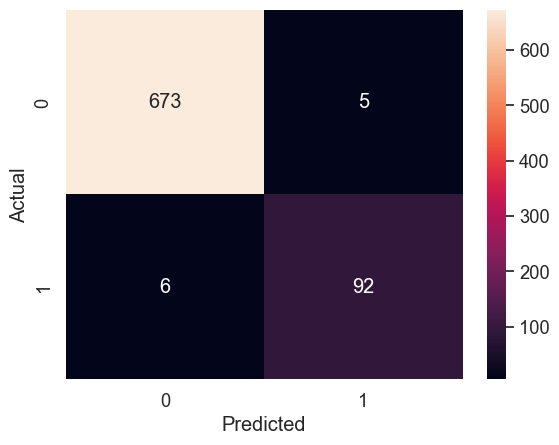

In [119]:
sns.heatmap(clw_cm, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [120]:
clw = classification_report(y_test, y_predict_clw, target_names=['Ham', 'Spam'])
print(clw)

              precision    recall  f1-score   support

         Ham       0.87      1.00      0.93       678
        Spam       0.00      0.00      0.00        98

    accuracy                           0.87       776
   macro avg       0.44      0.50      0.47       776
weighted avg       0.76      0.87      0.81       776



In [121]:
# Detection of examples
clw_inf = clw_model.predict(reviews)
clw_inf

1/1 [==============================] - 1s 896ms/step


array([[0.31555504],
       [0.33709228],
       [0.34629753],
       [0.34160677],
       [0.3247794 ]], dtype=float32)

## Hyperparameter Tuning with Keras Tuner (Class Weights)
<a class="anchor" id="11"></a>
[Table of Contents](#0.1)

In [122]:
%%time
# Initialize Keras Tuner with the existing model
tuner = kt.Hyperband(
    compile_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory=os.getcwd(),
    project_name='clw_model'
)

# Perform hyperparameter tuning
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

# Get the best model
best_model_clw = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from C:\Users\sathi\Career\Internship\AFAME\Spam SMS Detection\BERT\clw_model\tuner0.json
CPU times: total: 1.52 s
Wall time: 2.01 s


In [123]:
# Evaluate the best model on the validation set
hp_results_val_clw = best_model_clw.evaluate(X_val, y_val)
print(f"\nValidation Loss: {hp_results_val_clw[0]}")
print(f"Validation Accuracy: {hp_results_val_clw[1]}")

25/25 [==============================] - 12s 447ms/step - loss: 0.0446 - accuracy: 0.9484 - precision: 0.7266 - recall: 0.9490

Validation Loss: 0.044625263661146164
Validation Accuracy: 0.9484203457832336


In [124]:
# Evaluate the best model on the test set
hp_results_test_clw = best_model_clw.evaluate(X_test, y_test)
print(f"\Test Loss: {hp_results_test_clw[0]}")
print(f"Test Accuracy: {hp_results_test_clw[1]}")

25/25 [==============================] - 11s 430ms/step - loss: 0.0337 - accuracy: 0.9910 - precision: 1.0000 - recall: 0.9286
\Test Loss: 0.03372407332062721
Test Accuracy: 0.9909793734550476


## Model Building 
<a class="anchor" id="11.1"></a>
[Table of Contents](#0.1)

In [125]:
%%time
# Fitting best model on X_train, y_train, X_val, y_val, X_test, y_test
best_model_clw.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
114/114 [==============================] - 64s 539ms/step - loss: 0.0672 - accuracy: 0.9760 - precision: 0.9263 - recall: 0.8796 - val_loss: 0.0423 - val_accuracy: 0.9832 - val_precision: 0.9670 - val_recall: 0.8980 - lr: 0.0010
Epoch 2/20
114/114 [==============================] - 61s 532ms/step - loss: 0.0691 - accuracy: 0.9732 - precision: 0.9206 - recall: 0.8621 - val_loss: 0.0416 - val_accuracy: 0.9832 - val_precision: 0.9670 - val_recall: 0.8980 - lr: 0.0010
Epoch 3/20
114/114 [==============================] - 61s 534ms/step - loss: 0.0636 - accuracy: 0.9768 - precision: 0.9287 - recall: 0.8840 - val_loss: 0.0480 - val_accuracy: 0.9845 - val_precision: 0.9300 - val_recall: 0.9490 - lr: 0.0010
Epoch 4/20
114/114 [==============================] - 61s 533ms/step - loss: 0.0724 - accuracy: 0.9735 - precision: 0.9188 - recall: 0.8665 - val_loss: 0.0549 - val_accuracy: 0.9794 - val_precision: 0.9881 - val_recall: 0.8469 - lr: 0.0010
Epoch 5/20
114/114 [====================

## Model Evaluation
<a class="anchor" id="11.2"></a>
[Table of Contents](#0.1)

In [126]:
y_predict_hp_clw = best_model_clw.predict(X_test)
y_predict_hp_clw = y_predict_hp_clw.flatten()

25/25 [==============================] - 11s 424ms/step


In [127]:
y_predict_hp_clw = np.where(y_predict_hp_clw > 0.5,1,0)
y_predict_hp_clw

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

In [128]:
cm_hp_clw = confusion_matrix(y_test, y_predict_hp_clw)
cm_hp_clw

array([[677,   1],
       [  6,  92]], dtype=int64)

Text(43.25, 0.5, 'Actual')

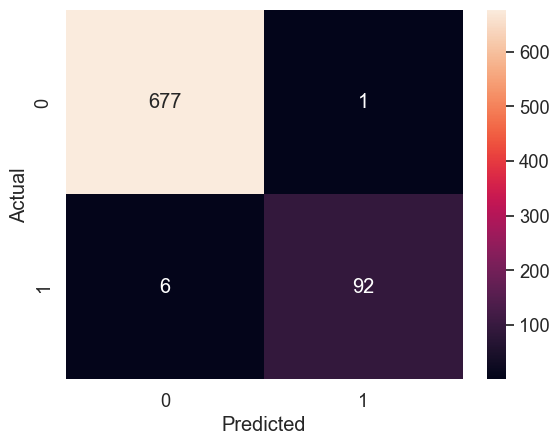

In [129]:
sns.heatmap(cm_hp_clw, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [130]:
cus_hp = classification_report(y_test, y_predict_hp_clw, target_names=['Ham', 'Spam'])
print(cus_hp)

              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       678
        Spam       0.99      0.94      0.96        98

    accuracy                           0.99       776
   macro avg       0.99      0.97      0.98       776
weighted avg       0.99      0.99      0.99       776



## Additional Metrics (ROC-AUC) for BERT
<a class="anchor" id="11.3"></a>
[Table of Contents](#0.1)

In [131]:
roc_auc_test = roc_auc_score(y_test, y_predict_hp_clw)
print(f'ROC-AUC Score on Test Set: {roc_auc_test:.4f}')

ROC-AUC Score on Test Set: 0.9687


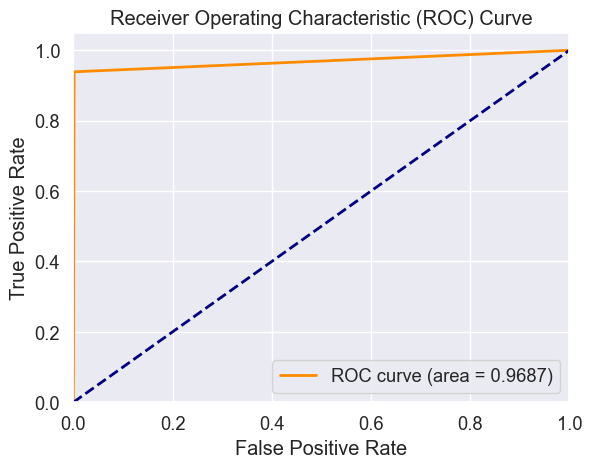

In [132]:
# Assuming y_test and y_predict_hp are already defined
fpr, tpr, _ = roc_curve(y_test, y_predict_hp_clw)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [133]:
# Detection of examples
clw_inf_hp = best_model_clw.predict(reviews)
clw_inf_hp

1/1 [==============================] - 1s 750ms/step


array([[0.04296187],
       [0.42120916],
       [0.17502187],
       [0.41391   ],
       [0.0019341 ]], dtype=float32)

## Custom Loss
<a class="anchor" id="12"></a>
[Table of Contents](#0.1)

In [134]:
%%time
cus_model = tf.keras.models.clone_model(model)  # Cloning the custom model architectire without learned weights

CPU times: total: 10.9 s
Wall time: 11.3 s


In [135]:
def custom_loss(y_train, y_predict):
    # Convert y_train to float
    y_train = tf.cast(y_train, tf.float32)
    
    # Apply label smoothing
    y_train_smoothed = y_train * 0.9 + 0.05

    # Compute binary cross-entropy
    bce_loss = tf.keras.losses.binary_crossentropy(y_train_smoothed, y_predict, from_logits=False)

    return bce_loss

In [136]:
%%time
cus_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss = custom_loss,
                  metrics = metrics)

CPU times: total: 31.2 ms
Wall time: 5 ms


## Model Building
<a class="anchor" id="12.1"></a>
[Table of Contents](#0.1)

In [137]:
%%time
# Fit the model
history_cus = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
114/114 [==============================] - 61s 532ms/step - loss: 0.0668 - accuracy: 0.9743 - precision: 0.9118 - recall: 0.8818 - val_loss: 0.0408 - val_accuracy: 0.9845 - val_precision: 0.9674 - val_recall: 0.9082 - lr: 2.0000e-04
Epoch 2/20
114/114 [==============================] - 60s 528ms/step - loss: 0.0740 - accuracy: 0.9751 - precision: 0.9124 - recall: 0.8884 - val_loss: 0.0415 - val_accuracy: 0.9832 - val_precision: 0.9670 - val_recall: 0.8980 - lr: 2.0000e-04
Epoch 3/20
114/114 [==============================] - 60s 524ms/step - loss: 0.0835 - accuracy: 0.9724 - precision: 0.9142 - recall: 0.8621 - val_loss: 0.0409 - val_accuracy: 0.9832 - val_precision: 0.9670 - val_recall: 0.8980 - lr: 2.0000e-04
Epoch 4/20
114/114 [==============================] - 59s 520ms/step - loss: 0.0644 - accuracy: 0.9779 - precision: 0.9294 - recall: 0.8928 - val_loss: 0.0409 - val_accuracy: 0.9858 - val_precision: 0.9677 - val_recall: 0.9184 - lr: 4.0000e-05
CPU times: total: 5min 3

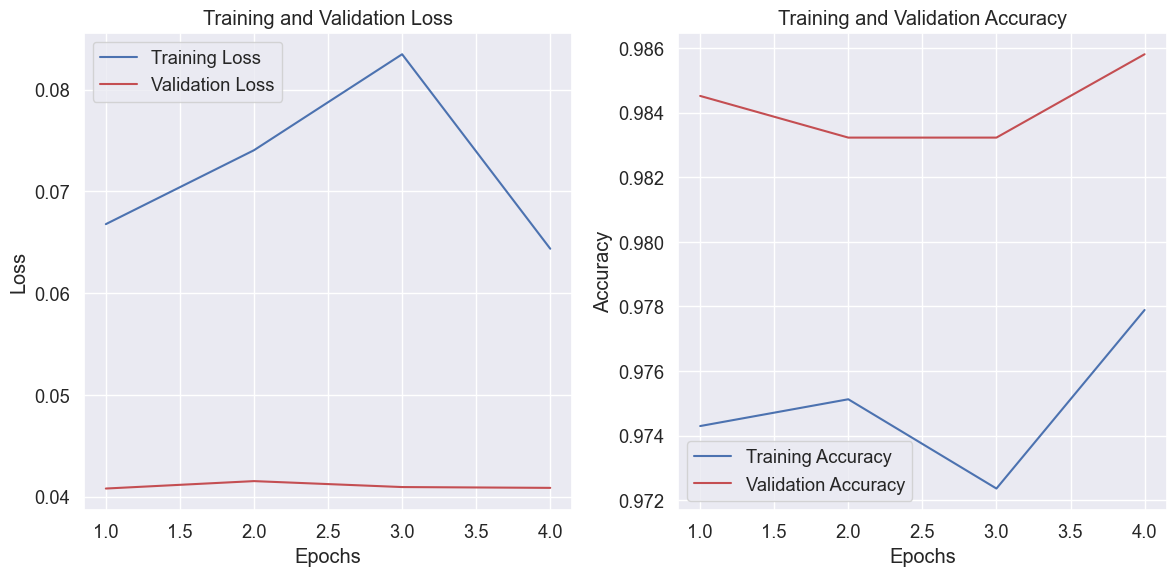

In [138]:
# Extract loss and accuracy for training and validation from the history object
train_loss = history_cus.history['loss']
val_loss = history_cus.history['val_loss']
train_accuracy = history_cus.history['accuracy']
val_accuracy = history_cus.history['val_accuracy']

# Create a range object for the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

## Model Evaluation
<a class="anchor" id="12.2"></a>
[Table of Contents](#0.1)

In [139]:
# Evaluate the model
results_cus = model.evaluate(X_test, y_test)
print(f"Test Loss: {results_cus[0]}")
print(f"Test Accuracy: {results_cus[1]}")

25/25 [==============================] - 10s 414ms/step - loss: 0.0288 - accuracy: 0.9923 - precision: 0.9894 - recall: 0.9490
Test Loss: 0.028787437826395035
Test Accuracy: 0.9922680258750916


In [140]:
y_predict_cus = cus_model.predict(X_test)
y_predict_cus = y_predict_cus.flatten()

25/25 [==============================] - 11s 414ms/step


In [141]:
y_predict_cus = np.where(y_predict_cus > 0.5,1,0)
y_predict_cus

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [142]:
cm_cus = confusion_matrix(y_test, y_predict_cus)
cm_cus

array([[  0, 678],
       [  0,  98]], dtype=int64)

Text(43.25, 0.5, 'Actual')

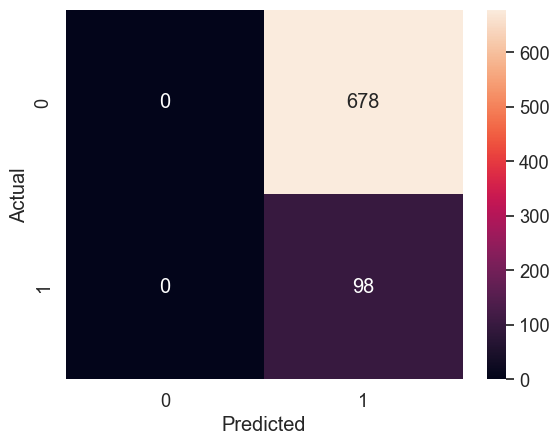

In [143]:
sns.heatmap(cm_cus, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [144]:
cus = classification_report(y_test, y_predict_cus, target_names=['Ham', 'Spam'])
print(cus)

              precision    recall  f1-score   support

         Ham       0.00      0.00      0.00       678
        Spam       0.13      1.00      0.22        98

    accuracy                           0.13       776
   macro avg       0.06      0.50      0.11       776
weighted avg       0.02      0.13      0.03       776



In [145]:
# Detection of examples
cus_inf = cus_model.predict(reviews)
cus_inf

1/1 [==============================] - 1s 715ms/step


array([[0.5919666 ],
       [0.61560005],
       [0.60953027],
       [0.6203045 ],
       [0.637023  ]], dtype=float32)

## Hyperparameter Tuning with Keras Tuner (Custom Loss)
<a class="anchor" id="13"></a>
[Table of Contents](#0.1)

In [146]:
%%time
# Initialize Keras Tuner with the existing model
tuner = kt.Hyperband(
    compile_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory=os.getcwd(),
    project_name='cus_model'
)

# Perform hyperparameter tuning
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

# Get the best model
best_model_cus = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from C:\Users\sathi\Career\Internship\AFAME\Spam SMS Detection\BERT\cus_model\tuner0.json
CPU times: total: 1.66 s
Wall time: 2.16 s


In [147]:
# Evaluate the best model on the validation set
hp_results_val_cus = best_model_cus.evaluate(X_val, y_val)
print(f"\nValidation Loss: {hp_results_val_cus[0]}")
print(f"Validation Accuracy: {hp_results_val_cus[1]}")

25/25 [==============================] - 11s 406ms/step - loss: 0.0396 - accuracy: 0.9884 - precision: 0.9785 - recall: 0.9286

Validation Loss: 0.039572760462760925
Validation Accuracy: 0.988394558429718


In [148]:
# Evaluate the best model on the test set
hp_results_test_cus = best_model_cus.evaluate(X_test, y_test)
print(f"\Test Loss: {hp_results_test_cus[0]}")
print(f"Test Accuracy: {hp_results_test_cus[1]}")

25/25 [==============================] - 10s 410ms/step - loss: 0.0280 - accuracy: 0.9923 - precision: 0.9894 - recall: 0.9490
\Test Loss: 0.027957065030932426
Test Accuracy: 0.9922680258750916


## Model Building
<a class="anchor" id="13.1"></a>
[Table of Contents](#0.1)

In [149]:
%%time
# Fitting best model on X_train, y_train, X_val, y_val, X_test, y_test
best_model_cus.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
114/114 [==============================] - 61s 515ms/step - loss: 0.0642 - accuracy: 0.9765 - precision: 0.9227 - recall: 0.8884 - val_loss: 0.0391 - val_accuracy: 0.9871 - val_precision: 0.9681 - val_recall: 0.9286 - lr: 0.0010
Epoch 2/20
114/114 [==============================] - 59s 517ms/step - loss: 0.0738 - accuracy: 0.9748 - precision: 0.9236 - recall: 0.8731 - val_loss: 0.0404 - val_accuracy: 0.9858 - val_precision: 0.9677 - val_recall: 0.9184 - lr: 0.0010
Epoch 3/20
114/114 [==============================] - 59s 518ms/step - loss: 0.0699 - accuracy: 0.9743 - precision: 0.9194 - recall: 0.8731 - val_loss: 0.0479 - val_accuracy: 0.9819 - val_precision: 0.9667 - val_recall: 0.8878 - lr: 0.0010
Epoch 4/20
114/114 [==============================] - 59s 521ms/step - loss: 0.0687 - accuracy: 0.9776 - precision: 0.9541 - recall: 0.8643 - val_loss: 0.0421 - val_accuracy: 0.9845 - val_precision: 0.9674 - val_recall: 0.9082 - lr: 2.0000e-04
CPU times: total: 5min 1s
Wall time:

## Model Evaluation
<a class="anchor" id="13.2"></a>
[Table of Contents](#0.1)

In [150]:
y_predict_hp_cus = best_model_cus.predict(X_test)
y_predict_hp_cus = y_predict_hp_cus.flatten()

25/25 [==============================] - 11s 426ms/step


In [151]:
y_predict_hp_cus = np.where(y_predict_hp_cus > 0.5,1,0)
y_predict_hp_cus

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

In [152]:
cm_hp_cus = confusion_matrix(y_test, y_predict_hp_cus)
cm_hp_cus

array([[677,   1],
       [  5,  93]], dtype=int64)

Text(43.25, 0.5, 'Actual')

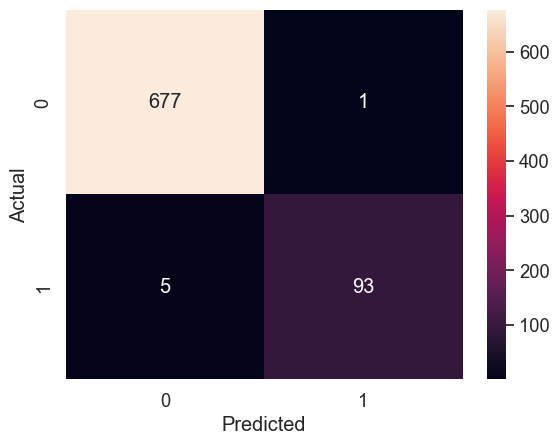

In [153]:
sns.heatmap(cm_hp_cus, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [154]:
cus_hp = classification_report(y_test, y_predict_hp_cus, target_names=['Ham', 'Spam'])
print(cus_hp)

              precision    recall  f1-score   support

         Ham       0.99      1.00      1.00       678
        Spam       0.99      0.95      0.97        98

    accuracy                           0.99       776
   macro avg       0.99      0.97      0.98       776
weighted avg       0.99      0.99      0.99       776



## Additional Metrics (ROC-AUC) for BERT
<a class="anchor" id="13.3"></a>
[Table of Contents](#0.1)

In [155]:
roc_auc_test = roc_auc_score(y_test, y_predict_hp_cus)
print(f'ROC-AUC Score on Test Set: {roc_auc_test:.4f}')

ROC-AUC Score on Test Set: 0.9738


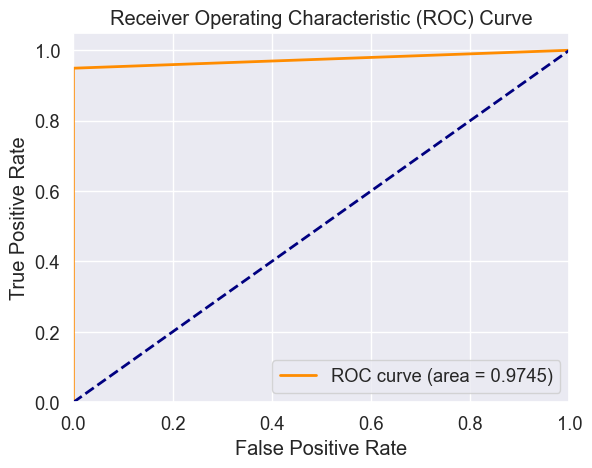

In [156]:
# y_test and y_predict_hp_cus are already defined
fpr, tpr, _ = roc_curve(y_test, y_predict_hp)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [157]:
# Detection of examples
cus_inf_hp = best_model_cus.predict(reviews)
cus_inf_hp

1/1 [==============================] - 1s 850ms/step


array([[0.0627556 ],
       [0.506941  ],
       [0.20083985],
       [0.4653539 ],
       [0.00232182]], dtype=float32)

## Performance Comparison of Fine-Tuned BERT
<a class="anchor" id="14"></a>
[Table of Contents](#0.1)

In [158]:
# Converting the actual classification report metrics into dictionaries
nml_metrics = classification_report(y_test, y_predict, target_names=['ham', 'spam'], output_dict=True)
dwn_metrics = classification_report(y_test_dwn, y_predict_dwn, target_names=['ham', 'spam'], output_dict=True)
up_metrics = classification_report(y_test_up, y_predict_up, target_names=['ham', 'spam'], output_dict=True)
clw_metrics = classification_report(y_test, y_predict_clw, target_names=['ham', 'spam'], output_dict=True)
cus_metrics = classification_report(y_test, y_predict_cus, target_names=['ham', 'spam'], output_dict=True)

# Create a DataFrame with the relevant metrics
metrics_df = pd.DataFrame({
    'Model': ['Original', 'Down Sampling', 'Up Sampling', 'Class Weights', 'Custom Loss'],
    'Accuracy': [nml_metrics['accuracy'], dwn_metrics['accuracy'], up_metrics['accuracy'], clw_metrics['accuracy'], cus_metrics['accuracy']],
    'Precision (ham)': [nml_metrics['ham']['precision'], dwn_metrics['ham']['precision'], up_metrics['ham']['precision'], clw_metrics['ham']['precision'], cus_metrics['ham']['precision']],
    'Precision (spam)': [nml_metrics['spam']['precision'], dwn_metrics['spam']['precision'], up_metrics['spam']['precision'], clw_metrics['spam']['precision'], cus_metrics['spam']['precision']],
    'Recall (ham)': [nml_metrics['ham']['recall'], dwn_metrics['ham']['recall'], up_metrics['ham']['recall'], clw_metrics['ham']['recall'], cus_metrics['ham']['recall']],
    'Recall (spam)': [nml_metrics['spam']['recall'], dwn_metrics['spam']['recall'], up_metrics['spam']['recall'], clw_metrics['spam']['recall'], cus_metrics['spam']['recall']],
    'F1-score (ham)': [nml_metrics['ham']['f1-score'], dwn_metrics['ham']['f1-score'], up_metrics['ham']['f1-score'], clw_metrics['ham']['f1-score'], cus_metrics['ham']['f1-score']],
    'F1-score (spam)': [nml_metrics['spam']['f1-score'], dwn_metrics['spam']['f1-score'], up_metrics['spam']['f1-score'], clw_metrics['spam']['f1-score'], cus_metrics['spam']['f1-score']],
    'Support (ham)': [nml_metrics['ham']['support'], dwn_metrics['ham']['support'], up_metrics['ham']['support'], clw_metrics['ham']['support'], cus_metrics['ham']['support']],
    'Support (spam)': [nml_metrics['spam']['support'], dwn_metrics['spam']['support'], up_metrics['spam']['support'], clw_metrics['spam']['support'], cus_metrics['spam']['support']]
})

# Display the comprehensive comparison table
metrics_df


,Model,Accuracy,Precision (ham),Precision (spam),Recall (ham),Recall (spam),F1-score (ham),F1-score (spam),Support (ham),Support (spam)
0,Original,0.985825,0.991163,0.948454,0.992625,0.938776,0.991894,0.943590,678.0,98.0
1,Down Sampling,0.959184,0.924528,1.000000,1.000000,0.918367,0.960784,0.957447,98.0,98.0
2,Up Sampling,0.984502,0.991031,0.978134,0.977876,0.991137,0.984410,0.984593,678.0,677.0
3,Class Weights,0.873711,0.873711,0.000000,1.000000,0.000000,0.932600,0.000000,678.0,98.0
4,Custom Loss,0.126289,0.000000,0.126289,0.000000,1.000000,0.000000,0.224256,678.0,98.0


## Performance Comparison of Hyperparameter-Tuned BERT
<a class="anchor" id="15"></a>
[Table of Contents](#0.1)

In [159]:
# Converting the actual classification report metrics into dictionaries
nml_metrics_hp = classification_report(y_test, y_predict_hp, target_names=['ham', 'spam'], output_dict=True)
dwn_metrics_hp = classification_report(y_test_dwn, y_predict_hp_dwn, target_names=['ham', 'spam'], output_dict=True)
up_metrics_hp = classification_report(y_test_up, y_predict_hp_up, target_names=['ham', 'spam'], output_dict=True)
clw_metrics_hp = classification_report(y_test, y_predict_hp_clw, target_names=['ham', 'spam'], output_dict=True)
cus_metrics_hp = classification_report(y_test, y_predict_hp_cus, target_names=['ham', 'spam'], output_dict=True)

# Create a DataFrame with the relevant metrics
metrics_hp_df = pd.DataFrame({
    'Model': ['Original', 'Down Sampling', 'Up Sampling', 'Class Weights', 'Custom Loss'],
    'Accuracy': [nml_metrics_hp['accuracy'], dwn_metrics_hp['accuracy'], up_metrics_hp['accuracy'], clw_metrics_hp['accuracy'], cus_metrics_hp['accuracy']],
    'Precision (ham)': [nml_metrics_hp['ham']['precision'], dwn_metrics_hp['ham']['precision'], up_metrics_hp['ham']['precision'], clw_metrics_hp['ham']['precision'], cus_metrics_hp['ham']['precision']],
    'Precision (spam)': [nml_metrics_hp['spam']['precision'], dwn_metrics_hp['spam']['precision'], up_metrics_hp['spam']['precision'], clw_metrics_hp['spam']['precision'], cus_metrics_hp['spam']['precision']],
    'Recall (ham)': [nml_metrics_hp['ham']['recall'], dwn_metrics_hp['ham']['recall'], up_metrics_hp['ham']['recall'], clw_metrics_hp['ham']['recall'], cus_metrics_hp['ham']['recall']],
    'Recall (spam)': [nml_metrics_hp['spam']['recall'], dwn_metrics_hp['spam']['recall'], up_metrics_hp['spam']['recall'], clw_metrics_hp['spam']['recall'], cus_metrics_hp['spam']['recall']],
    'F1-score (ham)': [nml_metrics_hp['ham']['f1-score'], dwn_metrics_hp['ham']['f1-score'], up_metrics_hp['ham']['f1-score'], clw_metrics_hp['ham']['f1-score'], cus_metrics_hp['ham']['f1-score']],
    'F1-score (spam)': [nml_metrics_hp['spam']['f1-score'], dwn_metrics_hp['spam']['f1-score'], up_metrics_hp['spam']['f1-score'], clw_metrics_hp['spam']['f1-score'], cus_metrics_hp['spam']['f1-score']],
    'Support (ham)': [nml_metrics_hp['ham']['support'], dwn_metrics_hp['ham']['support'], up_metrics_hp['ham']['support'], clw_metrics_hp['ham']['support'], cus_metrics_hp['ham']['support']],
    'Support (spam)': [nml_metrics_hp['spam']['support'], dwn_metrics_hp['spam']['support'], up_metrics_hp['spam']['support'], clw_metrics_hp['spam']['support'], cus_metrics_hp['spam']['support']]
})

# Display the comprehensive comparison table
metrics_hp_df


,Model,Accuracy,Precision (ham),Precision (spam),Recall (ham),Recall (spam),F1-score (ham),F1-score (spam),Support (ham),Support (spam)
0,Original,0.993557,0.992679,1.000000,1.000000,0.948980,0.996326,0.973822,678.0,98.0
1,Down Sampling,0.979592,0.989583,0.970000,0.969388,0.989796,0.979381,0.979798,98.0,98.0
2,Up Sampling,0.984502,0.980966,0.988095,0.988201,0.980798,0.984570,0.984433,678.0,677.0
3,Class Weights,0.990979,0.991215,0.989247,0.998525,0.938776,0.994857,0.963351,678.0,98.0
4,Custom Loss,0.992268,0.992669,0.989362,0.998525,0.948980,0.995588,0.968750,678.0,98.0


## Inference Comparison of Fine-Tuned BERT
<a class="anchor" id="16"></a>
[Table of Contents](#0.1)

In [160]:
# Reshape arrays to be 1-dimensional
nml_inf = nml_inf.reshape(-1)
dwn_inf = dwn_inf.reshape(-1)
up_inf = up_inf.reshape(-1)
clw_inf = clw_inf.reshape(-1)
cus_inf = cus_inf.reshape(-1)

inferences = {
    'Normal Inference': nml_inf,
    'Down Sampling Inference': dwn_inf,
    'Up Sampling Inference': up_inf,
    'Class Weights Inference': clw_inf,
    'Custom Loss Inference': cus_inf
}

inf = pd.DataFrame(inferences)

# Display the table
inf

,Normal Inference,Down Sampling Inference,Up Sampling Inference,Class Weights Inference,Custom Loss Inference
0,0.041896,0.010229,0.351277,0.315555,0.591967
1,0.528010,0.232877,0.808034,0.337092,0.615600
2,0.041873,0.071212,0.727107,0.346298,0.609530
3,0.298873,0.190261,0.904192,0.341607,0.620305
4,0.006345,0.002843,0.001178,0.324779,0.637023


## Inference Comparison of Hyperparameter-Tuned BERT
<a class="anchor" id="17"></a>
[Table of Contents](#0.1)

In [161]:
# Reshape arrays to be 1-dimensional
nml_inf_hp = nml_inf_hp.reshape(-1)
dwn_inf_hp = dwn_inf_hp.reshape(-1)
up_inf_hp = up_inf_hp.reshape(-1)
clw_inf_hp = clw_inf_hp.reshape(-1)
cus_inf_hp = cus_inf_hp.reshape(-1)

inferences_hp = {
    'Normal Inference': nml_inf_hp,
    'Down Sampling Inference': dwn_inf_hp,
    'Up Sampling Inference': up_inf_hp,
    'Class Weights Inference': clw_inf_hp,
    'Custom Loss Inference': cus_inf_hp
}

inf_up = pd.DataFrame(inferences_hp)

# Display the table
inf_up

,Normal Inference,Down Sampling Inference,Up Sampling Inference,Class Weights Inference,Custom Loss Inference
0,0.031395,0.232409,0.250894,0.042962,0.062756
1,0.551868,0.720646,0.835309,0.421209,0.506941
2,0.191628,0.836508,0.631627,0.175022,0.200840
3,0.440414,0.927045,0.852619,0.413910,0.465354
4,0.005027,0.001247,0.006469,0.001934,0.002322


## Conclusion
<a class="anchor" id="18"></a>
[Table of Contents](#0.1)

Based on the comparison of the Fine-tuned BERT model and the Hyperparameter-tuned BERT model for spam detection, it is evident that the **Hyperparameter-tuned BERT model with the Original configuration** demonstrates the highest F1-score for spam detection, achieving a value of **0.996326**. This indicates excellent performance in identifying spam messages while maintaining a perfect balance between precision and recall. 

In contrast, the Hyperparameter-tuned BERT model with **Up Sampling** also performs well, with an F1-score of **0.984433**, but it slightly falls short compared to the Original configuration. The **Down Sampling** approach achieves an F1-score of **0.979798**, reflecting solid performance but less optimal than the Original and Up Sampling methods. 

Other approaches, such as **Class Weights**, where weights are assigned to the data, show comparatively lower F1-scores for spam detection, achieving a value of **0.963351**. Similarly, the **Custom Loss** method, which involves label smoothing based on the data labels' ratio, achieves an F1-score of **0.968750** for spam detection. While these methods show promise, they are not as effective as the Original configuration.

These results indicate that using balanced data and maintaining the default class distribution (as in the Original configuration) yields the most accurate results for classifying text messages into ham or spam when applying Bidirectional Encoder Representation from Transformers (BERT). It highlights a superior balance between precision and recall for identifying spam, making the **Hyperparameter-tuned BERT model with the Original configuration** the most effective model among those tested.

Given these findings, the **Hyperparameter-tuned BERT model with the Original configuration** is recommended for optimal spam detection performance. This model is well-suited for real industry applications and is ready to be deployed. By saving this best-performing model, robust and reliable spam detection can be ensured in a production environment, enhancing the overall effectiveness and efficiency of the system.

## Deployment
<a class="anchor" id="19"></a>
[Table of Contents](#0.1)

In [170]:
# Save the entire model to a HDF5 file
best_model_nml.save('spam_detection_model.h5')


In [ ]:
# Save the model in SavedModel format
best_model_nml.save('saved_model/spam_detection_model')

In [ ]:
message = input("Enter your message: ")

# Preprocess the message
preprocessed_message = bert_preprocessor([message])
encoded_message = bert_encoder(preprocessed_message)

# Predict using the best model
result = best_model_nml.predict(encoded_message)
print(result)

if result[0] == 1:
    print("This has a high probability of being a spam message.")
else:
    print("This is not likely to be a spam message.")


## References
<a class="anchor" id="20"></a>
[Table of Contents](#0.1)

`www.google.com`  `www.stackoverflow.com`  `www.tensorflowhub.com`  `www.geeksforgeeks.com`  `www.youtube.com`  `www.copilot.com`  `www.chatgpt.com`